In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pickle
from functions import (datespace, timespace, input_time_scaler,
                       parse_time, parse_date, parse_datetime,
                       format_datetime_i, format_datetime_h,
                       reformat_datetime_hi, reformat_datetime_ih,
                       get_deep, get_light, get_rem, get_wake,
                       import_concat, expand_input_time, get_input_bed,
                       get_delta, get_delta_scale, get_p_day, get_diff, get_avg, get_var,
                       stitch_drop_append2, estimator_cv_scores, estimator_cv_scores2,
                      get_top5, get_bottom5)

from collections import defaultdict
from classes import (TimeScaler, AvgRatioFiller, MatrixPipeline, OneHotEncoder, 
                    ZeroFiller, ChainTransformer, StandardScaler, AvgFiller)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
import fitbit
from datetime import datetime, timedelta
import pickle

In [3]:
with open('/Users/Sehokim/capstone/data/access_token.pkl', 'rb') as a:
    access = pickle.load(a)
with open('/Users/Sehokim/capstone/data/access_token.pkl', 'rb') as r:
    refresh = pickle.load(r)
client_id = '22DGXK'
client_secret = '6bb599aceb4be6c3b3caa2163247ffee'

auth_client = fitbit.Fitbit(client_id,
                            client_secret,
                            access_token=access,
                            refresh_token=refresh)


In [4]:
start_date = '2019-02-23'
end_date = datetime.strftime(datetime.now(), '%Y-%m-%d')
dates = datespace(start_date, end_date)

print(f'\
Start Date: {start_date}\n\
  End Date: {end_date}\n\
  Duration: {len(dates)} days')

Start Date: 2019-02-23
  End Date: 2019-04-17
  Duration: 54 days


In [5]:
res = auth_client.time_series('activities/heart', base_date=start_date, end_date=end_date)
df = pd.DataFrame(res['activities-heart'])

def parse_hr_zone(x, zone):
    try:
        return x['heartRateZones'][zone]['minutes']
    except:
        return np.nan
    
heart = pd.DataFrame()
heart['date'] = df['dateTime'].apply(parse_date)
heart['zone0'] = df['value'].apply(parse_hr_zone, args=(0,))
heart['zone1'] = df['value'].apply(parse_hr_zone, args=(1,))
heart['zone2'] = df['value'].apply(parse_hr_zone, args=(2,))
heart['zone3'] = df['value'].apply(parse_hr_zone, args=(3,))

In [6]:
activity_paths = ['activities/calories', 'activities/steps','activities/minutesSedentary',
                     'activities/minutesLightlyActive','activities/minutesFairlyActive',
                     'activities/minutesVeryActive']
str_dates = np.array(list(map(str, dates))).reshape(-1,1)
activity = pd.DataFrame(str_dates, columns=['dateTime'])

for path in activity_paths:
    res = auth_client.time_series(path, base_date=start_date, end_date=end_date)
    df = pd.DataFrame(res[path.replace('/','-')])
    activity = activity.merge(df, on='dateTime', how='outer')
    column_names = ['date','cal','step','seden','lightly','fairly','very']
activity.columns = column_names
activity['date'] = activity['date'].apply(parse_date)

In [7]:
merged = activity.merge(heart, on='date', how='outer')
merged



,date,cal,step,seden,lightly,fairly,very,zone0,zone1,zone2,zone3
0,2019-02-23,2142,8043,647,213,32,28,NaN,NaN,NaN,NaN
1,2019-02-24,2086,11225,514,179,4,59,NaN,NaN,NaN,NaN
2,2019-02-25,2323,9567,1061,352,5,22,413.0,42.0,15.0,0.0
3,2019-02-26,2091,7841,678,314,0,0,1344.0,92.0,0.0,0.0
4,2019-02-27,2169,8812,517,362,0,0,1148.0,107.0,0.0,0.0
5,2019-02-28,2643,10327,949,466,15,10,694.0,352.0,0.0,0.0
6,2019-03-01,2511,11299,644,444,7,4,1186.0,244.0,0.0,0.0
7,2019-03-02,2325,12265,529,281,4,55,1200.0,219.0,2.0,0.0
8,2019-03-03,1657,2658,883,136,0,0,1402.0,35.0,0.0,0.0
9,2019-03-04,2014,6815,654,250,13,6,1310.0,107.0,0.0,0.0


# sleep 

In [8]:
res = auth_client.time_series('sleep', base_date=start_date, end_date=end_date)
df = pd.DataFrame(res['sleep'])

raw_all_sleep = pd.DataFrame()
raw_all_sleep['start'] = df['startTime'].apply(parse_datetime)
raw_all_sleep['end'] = df['endTime'].apply(parse_datetime)
raw_all_sleep['bed'] = df['timeInBed']
raw_all_sleep['asleep'] = df['minutesAsleep']
raw_all_sleep['awake'] = df['minutesAwake']
raw_all_sleep['effic'] = df['efficiency']
# sleep['awakening'] = df['levels'].apply(get_wake)
# sleep['Minutes REM Sleep'] = raw_sleep['levels'].apply(get_rem)
# sleep['Minutes Light Sleep'] = raw_sleep['levels'].apply(get_light)
# sleep['Minutes Deep Sleep'] = raw_sleep['levels'].apply(get_deep)

raw_all_sleep.sort_values('start', inplace=True)
raw_all_sleep.reset_index(inplace=True, drop=True)
sti_all_sleep = stitch_drop_append2(raw_all_sleep)


In [9]:
sti_all_sleep.head()

,start,end,bed,asleep,awake,effic
0,2019-02-22 23:51:30,2019-02-23 08:31:30,520.0,479.0,40.0,92.0
1,2019-02-23 23:23:30,2019-02-24 08:22:00,538.0,492.0,46.0,91.0
2,2019-02-24 15:26:00,2019-02-24 17:52:00,146.0,141.0,4.0,97.0
3,2019-02-25 21:59:30,2019-02-26 05:27:30,448.0,424.0,23.0,95.0
4,2019-02-26 20:33:30,2019-02-27 05:54:30,561.0,512.0,34.0,94.0


In [10]:


# 
sync_sleep_mask = \
((sti_all_sleep['start'].apply(lambda x: x.time()) >= datetime(1,1,1,17,0).time()) |\
(sti_all_sleep['start'].apply(lambda x: x.time()) < datetime(1,1,1,5,0).time())) &\
(sti_all_sleep['asleep'] >= 180)

# 4
sync_nap_mask = \
((sti_all_sleep['start'].apply(lambda x: x.time()) >= datetime(1,1,1,22,0).time()) |\
(sti_all_sleep['start'].apply(lambda x: x.time()) < datetime(1,1,1,10,0).time())) &\
(sti_all_sleep['asleep'] < 180)

# 7
async_sleep_mask = \
(sti_all_sleep['start'].apply(lambda x: x.time()) > datetime(1,1,1,5,0).time()) &\
(sti_all_sleep['start'].apply(lambda x: x.time()) < datetime(1,1,1,17,0).time()) &\
(sti_all_sleep['asleep'] >= 180)

# 31
async_nap_mask = \
(sti_all_sleep['start'].apply(lambda x: x.time()) > datetime(1,1,1,10,0).time()) &\
(sti_all_sleep['start'].apply(lambda x: x.time()) < datetime(1,1,1,22,0).time()) &\
(sti_all_sleep['asleep'] < 180)


In [11]:
# raw_nap
raw_nap = sti_all_sleep.loc[async_sleep_mask, :].copy()
raw_nap.reset_index(inplace=True, drop=True)
# sel_nap
sel_nap = pd.DataFrame()
sel_nap['date'] = raw_nap['start'].apply(lambda x: x.date())
sel_nap['nap'] = raw_nap['asleep']
sel_nap

,date,nap


In [12]:
# raw_sleep
raw_sleep = sti_all_sleep.loc[sync_sleep_mask, :].copy()
raw_sleep.reset_index(inplace=True, drop=True)
# sel_sleep
sel_sleep = raw_sleep[['start','end','bed','effic']]
sel_sleep

,start,end,bed,effic
0,2019-02-22 23:51:30,2019-02-23 08:31:30,520.0,92.0
1,2019-02-23 23:23:30,2019-02-24 08:22:00,538.0,91.0
2,2019-02-25 21:59:30,2019-02-26 05:27:30,448.0,95.0
3,2019-02-26 20:33:30,2019-02-27 05:54:30,561.0,94.0
4,2019-02-28 23:42:00,2019-03-01 05:23:30,341.0,91.0
5,2019-03-01 23:02:30,2019-03-02 08:34:00,571.0,95.0
6,2019-03-03 01:30:30,2019-03-03 08:31:30,421.0,90.0
7,2019-03-03 21:52:00,2019-03-04 06:29:30,517.0,96.0
8,2019-03-04 21:41:00,2019-03-05 05:45:00,484.0,95.0
9,2019-03-05 21:40:00,2019-03-06 05:47:30,487.0,94.0


In [42]:
# import and define user input start and end time
with open('/Users/Sehokim/capstone/data/start.pkl', 'rb') as s:
    raw_input_start = pickle.load(s)
    
with open('/Users/Sehokim/capstone/data/end.pkl', 'rb') as s:
    raw_input_end = pickle.load(s)
    
# apn_sleep
input_start = expand_input_time(raw_input_start)
input_end =  expand_input_time(raw_input_end)
input_bed = get_input_bed(input_start, input_end)
input_list = [input_start, input_end, input_bed]
input_dict = defaultdict()
for k, v in zip(sel_sleep.columns, input_list):
    input_dict[k] = v
    
input_df = pd.DataFrame(input_dict, index=[len(sel_sleep)])
apn_sleep = pd.concat([sel_sleep, input_df], axis=0, sort=False)

In [14]:
def get_sum(x):
    mask1 = exp_sleep.date < x
    mask2 = exp_sleep.date > x-timedelta(days=3)
    return exp_sleep.loc[mask1 & mask2, 'bed'].mean()
    

In [43]:
# exp_sleep
exp_sleep = pd.DataFrame()
exp_sleep['date'] = apn_sleep['end'].apply(lambda x: x.date()) - timedelta(days=1)
exp_sleep['day'] = exp_sleep['date'].apply(lambda x: x.weekday())
exp_sleep['start'] = apn_sleep['start']
exp_sleep['end'] = apn_sleep['end']
exp_sleep['bed'] = apn_sleep['bed']
exp_sleep['effic'] = apn_sleep['effic']
exp_sleep['delta'] = get_delta_scale(apn_sleep)

for i in range(7):
    i += 1
    exp_sleep[f'p{i}'] = get_p_day(exp_sleep, i)
exp_sleep['p1_diff'] = get_diff(exp_sleep, 'p1')
exp_sleep['p3_avg'] = get_avg(exp_sleep, 3)
exp_sleep['p7_avg'] = get_avg(exp_sleep, 7)
exp_sleep['p3_var'] = get_var(exp_sleep, 3)
exp_sleep['p7_var'] = get_var(exp_sleep, 7)
exp_sleep['p3_diff'] = get_diff(exp_sleep, 'p3_avg')
exp_sleep['p7_diff'] = get_diff(exp_sleep, 'p7_avg')
exp_sleep['p3_sum'] = exp_sleep['date'].apply(get_sum)

In [38]:
merged_sleep = exp_sleep.merge(sel_nap, on='date', how='left')
# merged = merged_sleep.merge(heart, on='date', how='left')\
# .merge(activity, on='date', how='left')\


merged.drop([
#                    'start','end','delta',
#                    'p1_diff','p3_diff','p7_diff','p3_var','p7_var',
#                    'p1','p2','p3','p4','p5','p6','p7','p3_avg','p7_avg'
], axis=1, inplace=True)

In [44]:
merged_sleep

,date,day,start,end,bed,effic,delta,p1,p2,p3,p4,p5,p6,p7,p1_diff,p3_avg,p7_avg,p3_var,p7_var,p3_diff,p7_diff,p3_sum,nap
0,2019-02-22,4,2019-02-22 23:51:30,2019-02-23 08:31:30,520.0,92.0,0.0,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,-9.0,00:00:00,00:00:00,0.000000,0.000000,-9.0,-9.0,NaN,NaN
1,2019-02-23,5,2019-02-23 23:23:30,2019-02-24 08:22:00,538.0,91.0,892.0,2019-02-22 23:51:30,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,-28.0,23:57:00,23:58:00,0.023112,0.015130,-34.0,-35.0,520.0,NaN
2,2019-02-25,0,2019-02-25 21:59:30,2019-02-26 05:27:30,448.0,95.0,817.5,2019-02-23 23:23:30,2019-02-22 23:51:30,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,-84.0,23:44:00,23:53:00,0.091098,0.064965,-105.0,-114.0,538.0,NaN
3,2019-02-26,1,2019-02-26 20:33:30,2019-02-27 05:54:30,561.0,94.0,906.0,2019-02-25 21:59:30,2019-02-23 23:23:30,2019-02-22 23:51:30,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,-86.0,23:04:00,23:36:00,0.315790,0.238090,-151.0,-183.0,448.0,NaN
4,2019-02-28,3,2019-02-28 23:42:00,2019-03-01 05:23:30,341.0,91.0,1067.5,2019-02-26 20:33:30,2019-02-25 21:59:30,2019-02-23 23:23:30,2019-02-22 23:51:30,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,189.0,21:58:00,23:08:00,0.500061,0.454706,104.0,34.0,561.0,NaN
5,2019-03-01,4,2019-03-01 23:02:30,2019-03-02 08:34:00,571.0,95.0,1059.0,2019-02-28 23:42:00,2019-02-26 20:33:30,2019-02-25 21:59:30,2019-02-23 23:23:30,2019-02-22 23:51:30,2000-01-01 00:00:00,2000-01-01 00:00:00,-40.0,22:04:00,23:05:00,0.547499,0.446821,58.0,-3.0,341.0,NaN
6,2019-03-02,5,2019-03-03 01:30:30,2019-03-03 08:31:30,421.0,90.0,1016.5,2019-03-01 23:02:30,2019-02-28 23:42:00,2019-02-26 20:33:30,2019-02-25 21:59:30,2019-02-23 23:23:30,2019-02-22 23:51:30,2000-01-01 00:00:00,148.0,22:26:00,22:56:00,0.578961,0.428002,184.0,154.0,456.0,NaN
7,2019-03-03,6,2019-03-03 21:52:00,2019-03-04 06:29:30,517.0,96.0,800.5,2019-03-03 01:30:30,2019-03-01 23:02:30,2019-02-28 23:42:00,2019-02-26 20:33:30,2019-02-25 21:59:30,2019-02-23 23:23:30,2019-02-22 23:51:30,-218.0,00:04:00,23:09:00,0.364150,0.505915,-132.0,-77.0,496.0,NaN
8,2019-03-04,0,2019-03-04 21:41:00,2019-03-05 05:45:00,484.0,95.0,911.5,2019-03-03 21:52:00,2019-03-03 01:30:30,2019-03-01 23:02:30,2019-02-28 23:42:00,2019-02-26 20:33:30,2019-02-25 21:59:30,2019-02-23 23:23:30,-11.0,23:26:00,22:51:00,0.528312,0.510725,-105.0,-70.0,469.0,NaN
9,2019-03-05,1,2019-03-05 21:40:00,2019-03-06 05:47:30,487.0,94.0,955.0,2019-03-04 21:41:00,2019-03-03 21:52:00,2019-03-03 01:30:30,2019-03-01 23:02:30,2019-02-28 23:42:00,2019-02-26 20:33:30,2019-02-25 21:59:30,-1.0,22:58:00,22:35:00,0.591904,0.515229,-78.0,-55.0,500.5,NaN


In [39]:
time_sc = ChainTransformer([TimeScaler()])
zero_sc = ChainTransformer([ZeroFiller()])
avg_sc = ChainTransformer([AvgFiller()])


branches = [
    ('start', time_sc), 
    ('end', time_sc),
    ('day', OneHotEncoder()),
    ('p1', time_sc),
    ('p2', time_sc),
    ('p3', time_sc),
    ('p4', time_sc),
    ('p5', time_sc),
    ('p6', time_sc),
    ('p7', time_sc),
    ('p3_avg', time_sc),
    ('p7_avg', time_sc),
    ('nap', zero_sc),
    ('get_top5', avg_sc),
    ('get_bottom5', avg_sc),
    ('mean', avg_sc),
    ('p3_sum', avg_sc),

]

mp = MatrixPipeline(branches)
mp.fit(merged_sleep)
Xy = mp.transform(merged_sleep)
Xy = Xy[7:].copy()
Xy.reset_index(inplace=True)
Xy.drop('index', axis=1, inplace=True)

y = Xy.pop('effic')
Xy.pop('date')
X = Xy

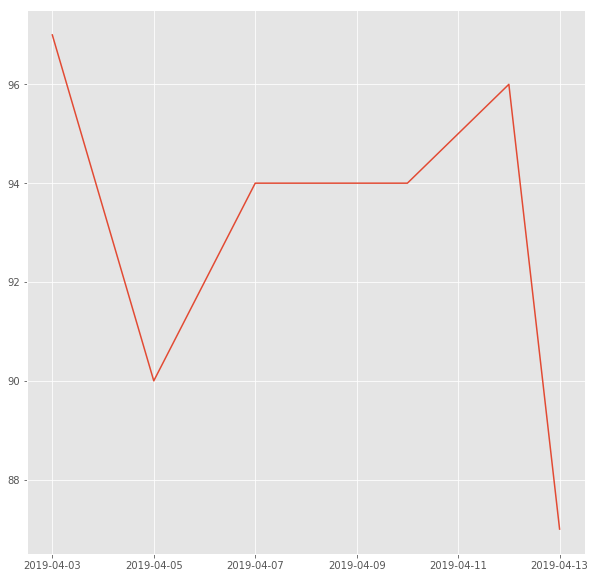

In [45]:
p7_dates = merged.loc[len(merged)-8:len(merged)-2, 'date']
p7_effic = y[-8:-1]
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(p7_dates,p7_effic)


In [46]:
rfr = RandomForestRegressor(1000)
rfr.fit(X[:len(X)-1],y[:len(X)-1])
y_ = rfr.predict(X[len(X)-1:])[0]
avg_p7_effic = np.mean(y[-8:-1])
result = (f'Estimated sleep efficiency for the night of {datetime.today().date()}: {y_:10.2f} out of 100',
f'Average sleep efficiency for the past 7 days: {avg_p7_effic:20.2f} out of 100')

result

('Estimated sleep efficiency for the night of 2019-04-17:      94.66 out of 100',
 'Average sleep efficiency for the past 7 days:                92.86 out of 100')